# Large deformation example

*Produces Figure (5)*

### Affiliations & E-mails
Flavio Lorez: [florez@ethz.ch](mailto:florez@ethz.ch)

¹: Computational Mechanics of Building Materials, ETH Zurich, Switzerland. 

### Environment setup
Special dependencies to run this notebook:
- `h5py` (and the HDF5 library)
- `mpi4py`
- `bamboost`, a python library built at CMBM for data management using HDF5.

To install `bamboost`:

```bash
git clone https://gitlab.ethz.ch/compmechmat/research/libs/bamboost.git
cd bamboost
pip install .
```
Alternatively to using `pip`, you can append the system path to find the package.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from bamboost import Manager

import utilities

> Please specify the path to the database (The data can be found on researchcollection/eth)

In [12]:
# Enter the path to the data
database_path = '../out-ironing'

db = Manager(database_path)
db

### Define functions used for plotting

In [14]:
def cmap_uni(color, color_negative='#ffffff00'):
    color_negative = list(color); color_negative[-2:] = ['0','0']; color_negative = "".join(color_negative)
    c = [color_negative, color]
    v = [0, 1]
    return mpl.colors.LinearSegmentedColormap.from_list('Uni', list(zip(v,c)), N=256)
    
    
def plot_schematic(ax, sim, step, xlim, ylim):
    blue, red = '#68a2b3ff', '#d9a9a9ff'
    
    # Load the data
    coords = sim.mesh[0]
    disk_phi = sim.data['disk_phi'].at_step(step).flatten()
    box_phi = sim.data['box_phi'].at_step(step).flatten()

    # Plot the phase field of the box
    tri = ax.tricontour(*coords.T, box_phi, cmap=cmap_uni(red), levels=np.linspace(0, 1.0001, 10),
                                    vmin=.1, vmax=.9, linewidths=.3)
    for col in tri.collections: col.set_rasterized(True)
    tri = ax.tricontourf(*coords.T, box_phi,
                                    cmap=cmap_uni(red), levels=np.linspace(.5, 1.001, 5))
    CS = ax.tricontour(*coords.T, box_phi, levels=[.5], linestyles='--', linewidths=.3)
    plt.clabel(CS, inline=1, fontsize=6, manual=[(3, 1)])

    # Plot the phase field of the disk
    tri = ax.tricontour(*coords.T, disk_phi, cmap=cmap_uni(blue), levels=np.linspace(0, 1.01, 10),
                                    vmin=.1, vmax=.9, linewidths=.3)
    tri = ax.tricontourf(*coords.T, disk_phi, cmap=cmap_uni(blue), levels=np.linspace(.5, 1.01, 5))
    for col in tri.collections: col.set_rasterized(True)
    CS = ax.tricontour(*coords.T, disk_phi, levels=[.5], linestyles='--', linewidths=.3)
    ax.set(xlim=xlim, ylim=ylim, xticks=[], yticks=[])
    plt.clabel(CS, inline=1, fontsize=6, manual=[(1.5, 3.5)])
    

def plot_step(bx, sim, step, xlim, ylim, arrows=False, label=1):

    cmap=mpl.cm.RdBu_r
    my_cmap=cmap(np.arange(cmap.N))
    my_cmap[:, -1] = np.linspace(0.3, 1, cmap.N)
    my_cmap = mpl.colors.ListedColormap(my_cmap)

    # Load the data
    coords = sim.mesh[0]
    box_vM = sim.data['box_vonMises'].at_step(step)
    disk_vM = sim.data['disk_vonMises'].at_step(step)
    disk_phi = sim.data['disk_phi'].at_step(step)
    box_phi = sim.data['box_phi'].at_step(step)

    vM_range = (0, 0.25)
    n = 20  # Nb of levels for the contourplot

    # Plot the von Mises stress for the box & the disk
    tric = bx.tricontourf(*coords[box_phi.flatten()>=.5].T,
                        box_vM[box_phi.flatten()>=.5].ravel(),
                        levels=np.linspace(*vM_range, n), cmap=my_cmap, vmin=vM_range[0], vmax=vM_range[1], zorder=-1, extend='max')
    for c in tric.collections: c.set_rasterized(True)
    tric = bx.tricontourf(*coords[disk_phi.flatten()>=.55].T,
                        disk_vM[disk_phi.flatten()>=.55].ravel(),
                        levels=np.linspace(*vM_range, n), cmap=my_cmap, vmin=vM_range[0], vmax=vM_range[1], extend='max')
    for c in tric.collections: c.set_rasterized(True)
        
    # Plot the 0.5 level for the box & the disk
    bx.tricontour(*coords.T, box_phi.flatten(), levels=[.5], linewidths=.5, )
    bx.tricontour(*coords.T, disk_phi.flatten(), levels=[.5], linewidths=.5, )
    
    # Some figure tweaks
    bx.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    bx.xaxis.set_major_formatter(lambda x, pos: str(int(x-2)))
    bx.set(xlim=xlim, ylim=ylim)

    if arrows:
        contact_point = coords[((disk_phi*box_phi)>.25).flatten()].mean(axis=0)
        bx.arrow(*contact_point, sim.globals.contact_force_x[step], sim.globals.contact_force_y[step], edgecolor='k', width=.05, facecolor='1.0', head_width=.2,)
        bx.arrow(*contact_point, -sim.globals.contact_force_x[step], -sim.globals.contact_force_y[step], edgecolor='k', width=.05, facecolor='1.0', head_width=.2, )
        
    # Annotate the number in the circle
    bx.annotate(text=rf'{{\raisebox{{.5pt}}{{\textcircled{{\raisebox{{-.9pt}} {label}}}',
                xy=(.05, .95), xycoords=bx.transAxes,
                ha='left', va='top',
    )

    return tric
    

def plot_traction(ax, sim, steps):

    # Load the data
    pos_x = sim.globals.position_x
    f_x = np.abs(sim.globals.contact_force_x)
    f_y = np.abs(sim.globals.contact_force_y)

    ax.plot(pos_x, f_x, label=r'$F_x$', ls='-', lw=1, c='tab:blue')
    ax.plot(pos_x, f_y, label=r'$F_y$', mfc='None', lw=1, c='0.2', ls='--')
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(lambda x, pos: str(x-2))
    ax.set(
        xlabel=r'$\bar{u}_x$',
        ylabel='$F$',
        ylim=(0, 0.39)
    )
    
    # Annotate the number in circle to indicate shown steps
    def circle(step, label):
        ax.annotate(text=rf'{{\raisebox{{.5pt}}{{\textcircled{{\raisebox{{-.9pt}} {label}}}',
                    xy=(pos_x[step], f_y[step]+.04),
                    ha='center', va='center',
        )
    for s, i in zip(steps, range(len(steps))):
        circle(s, i+1)
    

### Figure

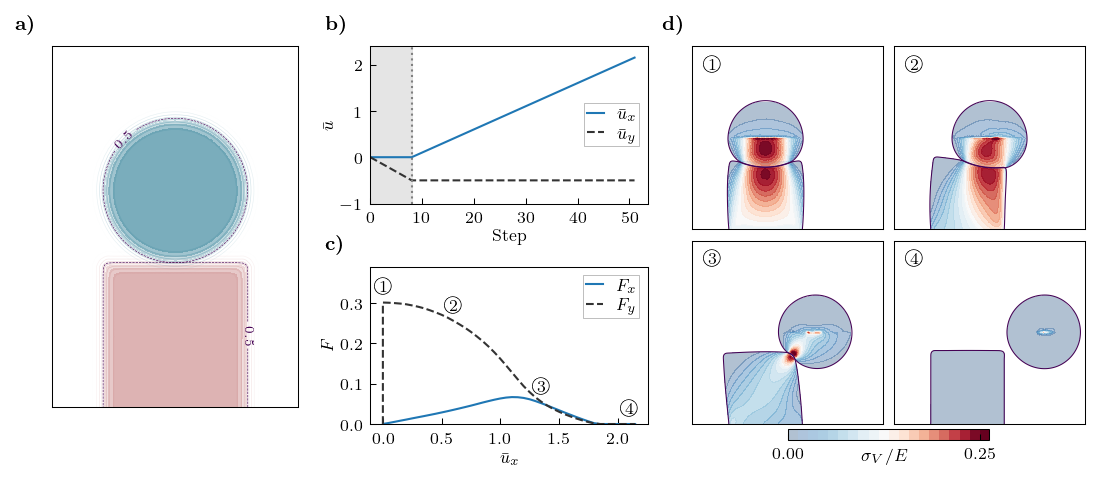

In [16]:
utilities.set_plot_theme()
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 2

# Select the simulation from the database
sim = db['78a08e4a']

# Setup figure layout
fig = plt.figure(figsize=(7.4, 2.8))
w, h = fig.get_size_inches()
fig_ratio = w/h
height = .9
left = .05
bottom = .05
w_pad, h_pad = .04, .15
height_half = (height-h_pad) / 2
width_second = .25
offset_schematic = .04

xlim=(.3, 3.7)
ylim=(0, 5)
data_ratio = (xlim[1]-xlim[0]) / (ylim[1]-ylim[0])

# SCHEMATIC (a)

ax = fig.add_axes((left, bottom+offset_schematic, data_ratio*(height-offset_schematic)/fig_ratio, height-offset_schematic))
plot_schematic(ax, sim, 0, xlim, ylim)

# CONTACT TRACTION (c)

steps = [8, 20, 35, 50]
bx = fig.add_axes((ax.get_position().x1+w_pad+.025, bottom, width_second, height_half))
plot_traction(bx, sim, steps=steps)

# PRESCRIBED MOTION (b)

cx = fig.add_axes((bx.get_position().x0, bottom+height_half+h_pad, width_second, height_half))
cx.plot(sim.globals.position_x-sim.globals.position_x[0], label=r'$\bar{u}_x$', c='tab:blue')
cx.plot(sim.globals.position_y-sim.globals.position_y[0], label=r'$\bar{u}_y$', c='0.2', ls='--')
cx.axvspan(0, 8, color='k', alpha=0.1)
cx.axvline(8, ls='dotted', color='0.5')
cx.set(
    xlabel='Step',
    ylabel=r'$\bar{u}$',
    xlim=(0, None),
    ylim=(-1, 2.4),
)
cx.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
cx.legend(loc='right')

# INDIVIDUAL STEP FIGURES (d)

xlim=(0, 5.2)
ylim=(0, 5)
data_ratio = (xlim[1]-xlim[0]) / (ylim[1]-ylim[0])

# axes setup
h_pad_steps = .01 * fig_ratio
height_steps = (height-h_pad_steps) / 2
w_pad_steps = .01
width_steps = height_steps*data_ratio/fig_ratio
axs = [None]*4
axs[0] = fig.add_axes((bx.get_position().x1+w_pad, bottom+height_steps+h_pad_steps, width_steps, height_steps))
axs[1] = fig.add_axes((axs[0].get_position().x1+w_pad_steps, bottom+height_steps+h_pad_steps, width_steps, height_steps))
axs[2] = fig.add_axes((bx.get_position().x1+w_pad, bottom, width_steps, height_steps))
axs[3] = fig.add_axes((axs[2].get_position().x1+w_pad_steps, bottom, width_steps, height_steps))

# Plot each subfigure
for axi, step, i in zip(axs, steps, range(len(axs))):
    cb = plot_step(axi, sim, step, xlim, ylim, label=i+1)
    axi.set(xticks=[], yticks=[], xlabel='', ylabel='')
    
# Add the colorbar
cb_rect = [
    axs[2].get_position().x0 + .5*axs[1].get_position().width,
    .25 * bottom,
    width_steps + w_pad_steps,
    .5 * bottom
]
cbax = fig.add_axes(cb_rect)
cb = plt.colorbar(cb, cbax, orientation='horizontal', extendrect=True)
cb.set_label(r'$\sigma_V/E$', labelpad=-7)
cb.set_ticks([0, 0.25])

# Add subplot labels
utilities.subplot_label(ax, 'a', -.25)
utilities.subplot_label(bx, 'c', -.3)
utilities.subplot_label(cx, 'b', -.3)
utilities.subplot_label(axs[0], 'd', -.2)

fig.savefig('figs/figure_box_alternative.pdf', dpi=600, bbox_inches='tight', pad_inches=0)